# <u>Chapter 9</u>: Generating Text in Chatbots

In [2]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'numpy', 'torch', 'transformers', 'torchtext', 'torchdata', 'portalocker'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)


# Building a language model

Let's define the `Transformer` model.

In [3]:
%matplotlib inline
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:

        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:

    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

The _PositionalEncoding_ class injects some information about the relative or absolute position of the tokens in the sequence.

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

Next, let's Load and batch the data.

In [5]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
  
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:

    seq_len = data.size(0) // bsz
    print(data.size(0))
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

2049990
214417
241859


The _get_batch_ method generates a pair of input-target sequences for the transformer model.

In [6]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:

    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)

    return data, target

Initiate a transformer instance.


In [7]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

Let's create a _writer_ object to log various information.

In [8]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

print('Current run is: ' + writer.get_logdir())

Current run is: runs\Nov11_19-23-41_CL-5CG10472MV


In [9]:
# Create a sample input for the transformer.
data, targets = get_batch(val_data, 0)
src_mask = generate_square_subsequent_mask(bptt).to(device)

# Log the graph of the model.
writer.add_graph(model, (data.to(device), src_mask))

Let's define the _train_ and _evaluate_ methods.

In [10]:
import numpy as np
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    
    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)

        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            
            # Log the summary for the loss.
            writer.add_scalar('Loss/train', cur_loss, (epoch-1)*num_batches+batch)

            # Log the summary for the time.
            writer.add_scalar('Time/train', ms_per_batch, (epoch-1)*num_batches+batch)

            # Log the summary for the time.
            writer.add_scalar('Perplexity/train', ppl, (epoch-1)*num_batches+batch)
            
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()

    return total_loss / (len(eval_data) - 1)

We can now start the training and evaluation processes.

<ins>Warning</ins>: The following code will take several hours to complete. Consider reducing the number of epochs.


In [11]:
best_val_loss = float('inf')
epochs = 20
best_model = None

# Iterate over all epochs.
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)
    
    # Log the summary for the loss.
    writer.add_scalar('Loss/eval', val_loss, epoch)

    # Log the summary for the time.
    writer.add_scalar('Time/eval', elapsed, epoch)

    # Log the summary for the time.
    writer.add_scalar('Perplexity/eval', val_ppl, epoch)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()


writer.close()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 518.90 | loss  8.15 | ppl  3474.82
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 540.95 | loss  6.91 | ppl  1000.11
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 629.02 | loss  6.45 | ppl   630.29
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 649.48 | loss  6.32 | ppl   553.04
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 699.58 | loss  6.20 | ppl   491.07
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 524.69 | loss  6.16 | ppl   475.39
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 424.30 | loss  6.12 | ppl   455.91
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 438.58 | loss  6.11 | ppl   450.00
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 428.63 | loss  6.03 | ppl   417.58
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 423.77 | loss  6.02 | ppl   412.11
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 426.86 | loss  5.90 | ppl   364.75
| epoch   

Finally, we can evaluate the best model on the test dataset.

In [12]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.43 | test ppl   227.85


## Tensorboard

`Tensoboard` is an open-source tool to track the output of machine learning experiments and visualize different quantities during the workflow. 

In [13]:
%load_ext tensorboard

%tensorboard --logdir runs/

Executing the following command initiates the process of gathering all the relevant files from the local repository and uploading them to the service.

In [14]:
!tensorboard dev upload \
  --logdir runs \
  --name "My ML4Text experiment" \
  --description "Comparing two language models" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/KnlMqngASeuOg7t9jvz0EQ/

[2022-11-12T16:10:58] Started scanning logdir.
Data upload starting...
Uploading binary object (67.9 kB)...
Uploading binary object (67.9 kB)...
Uploading binary object (67.9 kB)...
Uploading binary object (67.9 kB)...
Uploading binary object (67.9 kB)...
Uploading 1653 scalars...
[2022-11-12T16:11:03] Total uploaded: 1653 scalars, 0 tensors, 5 binary objects (339.6 kB)
[2022-11-12T16:11:03] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/KnlMqngASeuOg7t9jvz0EQ/


## XKCD

`XKCD` (https://xkcd.com/) is a famous webcomic based on statements on life and love, mathematical, programming, and scientific inside jokes. 

We present the validation loss for each epoch and annotation that points to the best mode

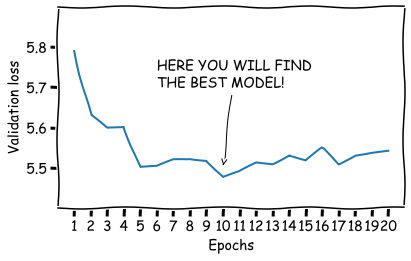

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Sample validation loss for 20 epochs.
val_loss_array = [5.79, 5.63, 5.599, 5.603, 5.502, 5.503, 5.52, 5.523, 5.52, 5.477, 5.49, 5.513, 5.511, 5.533, 5.518, 5.549, 5.509, 5.533, 5.539, 5.542]

# Create an xkcd plot that shows which epoch produced the best model.
with plt.xkcd():

    fig = plt.figure()
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.set_yticks([5.5, 5.6, 5.7, 5.8])
    plt.xticks(np.arange(20), np.arange(1, 21))
    ax.set_ylim([5.4, 5.9])

    # Include an annotation pointing to the best model.
    ax.annotate(
        'HERE YOU WILL FIND\nTHE BEST MODEL!',
        xy=(9, 5.5), arrowprops=dict(arrowstyle='->'), xytext=(5, 5.7))

    ax.plot(val_loss_array)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Validation loss')
    fig.text(0.5, 0.05, '', ha='center')

The following method creates a stick figure, with a callout.

In [16]:
# Create the stick figure.
def stick_figure(ax, x=.5, y=.5, radius=.03, callout=None, color='k', lw=2, xytext=(0, 20)):
    
    # Draw the head.
    head = plt.Circle((x, y), radius=radius, transform=ax.transAxes, 
                      edgecolor=color, lw=lw, facecolor='none', zorder=10)
    ax.add_patch(head)
    
    # Draw the body.
    body = plt.Line2D([x, x], [y-radius, y-(radius * 4)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(body)
    
    # Draw the arms.
    left_arm = plt.Line2D([x, x-(radius * .8)], [y-(radius * 1.5), y-(radius*5)], 
                    color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(left_arm)
    right_arm = plt.Line2D([x, x+(radius)], [y-(radius * 1.5), y-(radius*5)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(right_arm)

    # Draw the legs.
    left_leg = plt.Line2D([x, x-(radius*.5)], [y-(radius * 4), y-(radius*8)], 
                      color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(left_leg)
    right_leg = plt.Line2D([x, x+(radius)], [y-(radius * 4), y-(radius*8)], 
                    color=color, lw=lw, transform=ax.transAxes)
    ax.add_line(right_leg)
    
    # Show the message of the figure.
    if callout:
        ax.annotate(callout, xy=(x+radius, y+radius), xytext=xytext,
                    xycoords='axes fraction', textcoords='offset points',
                    arrowprops=dict(arrowstyle='-', lw=1))

We can also print the architecture of the model created earlier.

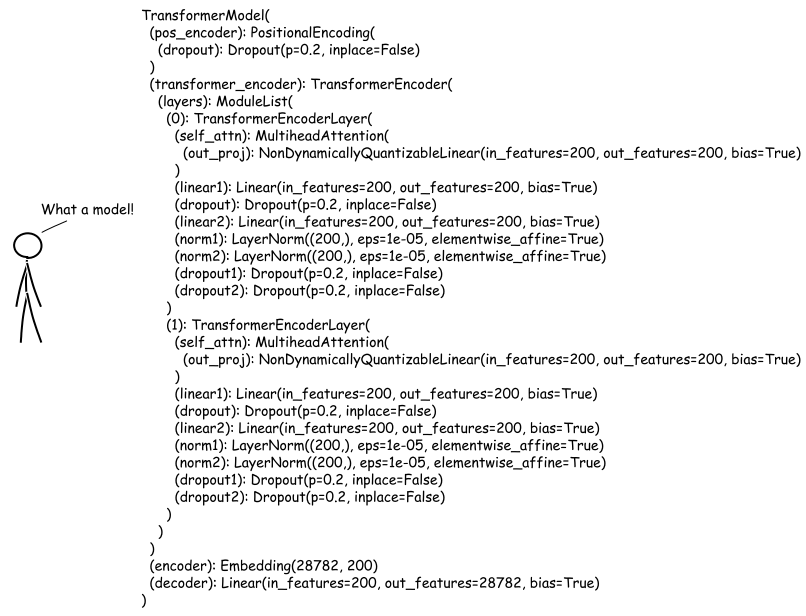

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# Create an xkcd plot that shows the model's architecture.
with plt.xkcd():

    fig, ax = plt.subplots(figsize=(12, 11))
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

    # Include an annotation with the model's architecture.
    ax.annotate(best_model, xy=(0.2, 0.))
   
    # Draw the figure.
    stick_figure(ax, x=.03, y=.6, radius=.02, callout='What a model!')
    

## What we have learned …

| | |
| --- | --- |
| **Visualizations**<ul><li>XKCD plots</li></ul> | **Tools**<ul><li>Tensorboard</li></ul> |
| | |